# 3   Splitting datasets one feature at a time: decision trees

## 3.1   Tree construction

### 3.1.1   Information gain

In [7]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'

***Listing 3.1*   Function to calculate the Shannon entropy of a dataset: `calcShannonEnt()`**

In [8]:
from math import log

In [9]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1   # Create dictionary of all possible classes
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob, 2)   # Logarithm based 2
    return shannonEnt

In [10]:
def createDataSet():
    dataSet = [[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

In [11]:
myDat, labels = createDataSet()
print(myDat)
calcShannonEnt(myDat)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]


0.9709505944546686

Now make the data a little messier to see if the entropy will increase.

In [12]:
myDat[0][-1] = 'maybe'
print(myDat)
calcShannonEnt(myDat)

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]


1.3709505944546687

### 3.1.2   Splitting the dataset

***Listing 3.2*   Dataset splitting on a given feature: `splitDataSet()`**

In [16]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []   # Create separate list
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)   # Cut on the feature split on
    return retDataSet

In [17]:
myDat, labels = createDataSet()
print(myDat)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]


In [18]:
splitDataSet(myDat, 0, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [19]:
splitDataSet(myDat, 0, 0)

[[1, 'no'], [1, 'no']]

***Listing 3.3*   Choosing the best feature to split on: `chooseBestFeatureToSplit()`**

In [20]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)   # Create unique list of class labels 
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)   # Calculate entropy for each split
        infoGain = baseEntropy - newEntropy
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i   # Find the best information gain
    return bestFeature

In [21]:
myDat, labels = createDataSet()
print(myDat)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]


In [22]:
chooseBestFeatureToSplit(myDat)

0

### 3.1.3   Recursively building the tree

In [23]:
import operator

In [24]:
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key = operator.itemgetter(1), reverse = True)
    return sortedClassCount[0][0]

***Listing 3.4*   Tree-building code: `createTree()`**

In [25]:
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]   # Stop when all classes are equal
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)   # When no more features, return majority
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)   # Get list of unique values
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

In [26]:
myDat, labels = createDataSet()

In [27]:
myTree = createTree(myDat, labels)
print(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


## 3.2   Plotting trees in Python with Matplotlib annotations

### 3.2.1   Matplotlib annotations

***Listing 3.5*   Plotting tree nodes with text annotations: `plotNode()` & `createPlot()`**

In [28]:
import matplotlib.pyplot as plt

In [34]:
decisionNode = dict(boxstyle = "sawtooth", fc = "0.8")
leafNode = dict(boxstyle = "round4", fc = "0.8")
arrow_args = dict(arrowstyle = "<-")   # Define box and arrow formatting

In [35]:
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy = parentPt, xycoords = 'axes fraction', xytext = centerPt, 
                            textcoords = 'axes fraction', va = "center", ha = "center", bbox = nodeType, 
                            arrowprops = arrow_args)   # Draw annotations with arrows

In [36]:
def createPlot():
    fig = plt.figure(1, facecolor = 'white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon = False)
    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

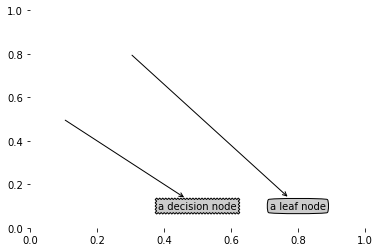

In [37]:
createPlot()

### 3.2.2   Constructing a tree of annotations

***Listing 3.6*   Identifying the number of leaves in a tree and the depth: `getNumLeafs()` & `getTreeDepth()`**

In [43]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    # In Python3, 'dict_keys' object is not subscriptable, so it should be converted into list in advance
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])   # Test if node is dictionary
        else:
            numLeafs += 1
    return numLeafs

`getNumLeafs()` counts the leaf nodes and returns the number.

In [48]:
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

`getTreeDepth()` counts the number of times hitting a decision node.

In [45]:
def retrieveTree(i):
    listOfTrees = [{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}, 
                   {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}]
    return listOfTrees[i]

Using the function above to output premade trees.

In [46]:
retrieveTree(1)

{'no surfacing': {0: 'no',
  1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}

In [49]:
myTree = retrieveTree(0)
getNumLeafs(myTree)
getTreeDepth(myTree)

3

2

***Listing 3.7*   The `plotTree` function**

In [50]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)   # PLots text between child ans parent

In [54]:
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)   # Get the width and height
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt) 
    plotNode(firstStr, cntrPt, parentPt, decisionNode) 
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict': 
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW 
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

In [52]:
def createPlot(inTree):
    fig = plt.figure(1, facecolor = 'white')
    fig.clf()
    axprops = dict(xticks = [], yticks = [])
    createPlot.ax1 = plt.subplot(111, frameon = False, **axprops) 
    plotTree.totalW = float(getNumLeafs(inTree)) 
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = - 0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

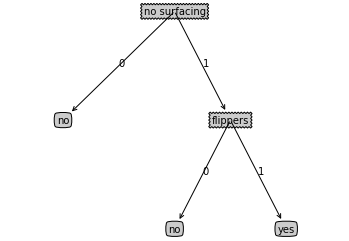

In [55]:
myTree = retrieveTree(0)
createPlot(myTree)

In [56]:
myTree['no surfacing'][3] = 'maybe'
print(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}}


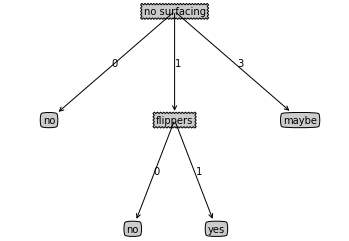

In [57]:
createPlot(myTree)

## 3.3   Testing and storing the classifier

### 3.3.1   Test: using the tree for classification

***Listing 3.8*   Classification function for an existing decision tree: `classify()`**

In [58]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)   # Translate label string to index
    for key in list(secondDict.keys()):
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [59]:
myDat, labels = createDataSet()
print(labels)

['no surfacing', 'flippers']


In [60]:
myTree = retrieveTree(0)
print(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


In [61]:
classify(myTree, labels, [1,0])
classify(myTree, labels, [1,1])

'no'

'yes'

### 3.3.2   Use: persisting the decision tree

***Listing 3.9*   Method for persisting the decision tree with pickle: `storeTree()` & `grabTree()`**

In [62]:
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename, 'w')
    pickle.dump(inputTree, fw)
    fw.close()

In [63]:
def grabTree(filename):
    import pickle
    fr = open(filename)
    return pickle.load(fr)

## 3.4   Example: using decision trees to predict contact lens type

In [64]:
fr = open('/Users/duoduo/Desktop/Data/Machine Learning/Machine Learning in Action/MLA_SourceCode/Ch03/lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)

In [65]:
print(lensesTree)

{'tearRate': {'reduced': 'no lenses', 'normal': {'astigmatic': {'no': {'age': {'young': 'soft', 'pre': 'soft', 'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}}}, 'yes': {'prescript': {'myope': 'hard', 'hyper': {'age': {'young': 'hard', 'pre': 'no lenses', 'presbyopic': 'no lenses'}}}}}}}}


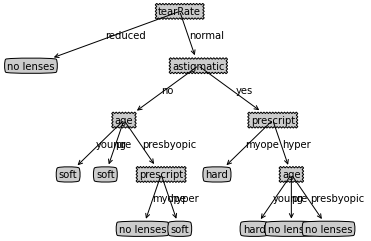

In [66]:
createPlot(lensesTree)